# Rotation trial

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import math
from skimage.transform import rotate
from scipy.ndimage import shift

from typing import Optional
from scipy import ndimage



global min, max: 0, 1000
or size: (512, 512)
or_center: (347.5, 255.5)
255.5 255.5
ormask: (512, 512)
angle: 10.922804719869262
New pixel location after rotation: (255.5, 342.5775516422)
or size: (512, 512)
or_center: (347.5, 255.5)
255.5 255.5
Shifting by (y,x): (4.922448357800022, 0)
center_y: 255.5., new_y: 342.5775516422., OR_center: 347.5 
masked


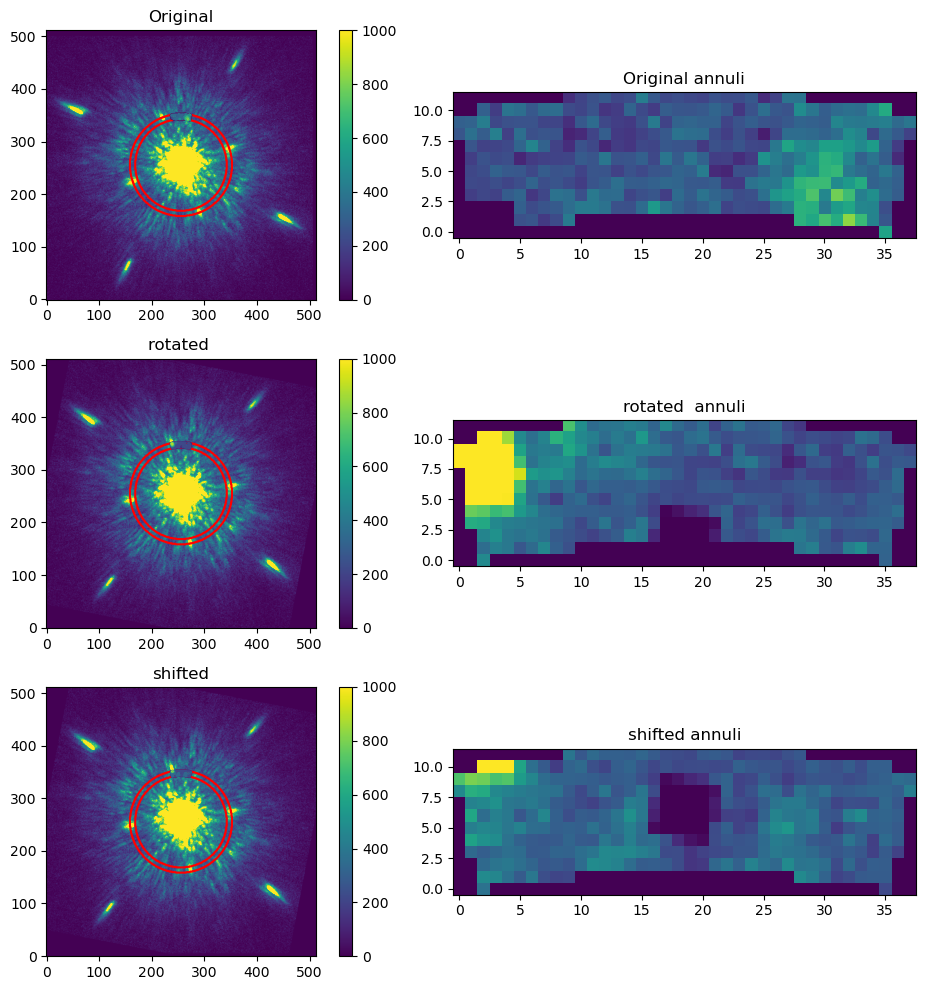

angle: -10.922804719869248
New pixel location after rotation: (255.50000000000006, 342.5775516422)
or size: (512, 512)
or_center: (347.5, 255.5)
255.5 255.5
Shifting by (y,x): (4.922448357800022, 0)
center_y: 255.5., new_y: 342.5775516422., OR_center: 347.5 
masked


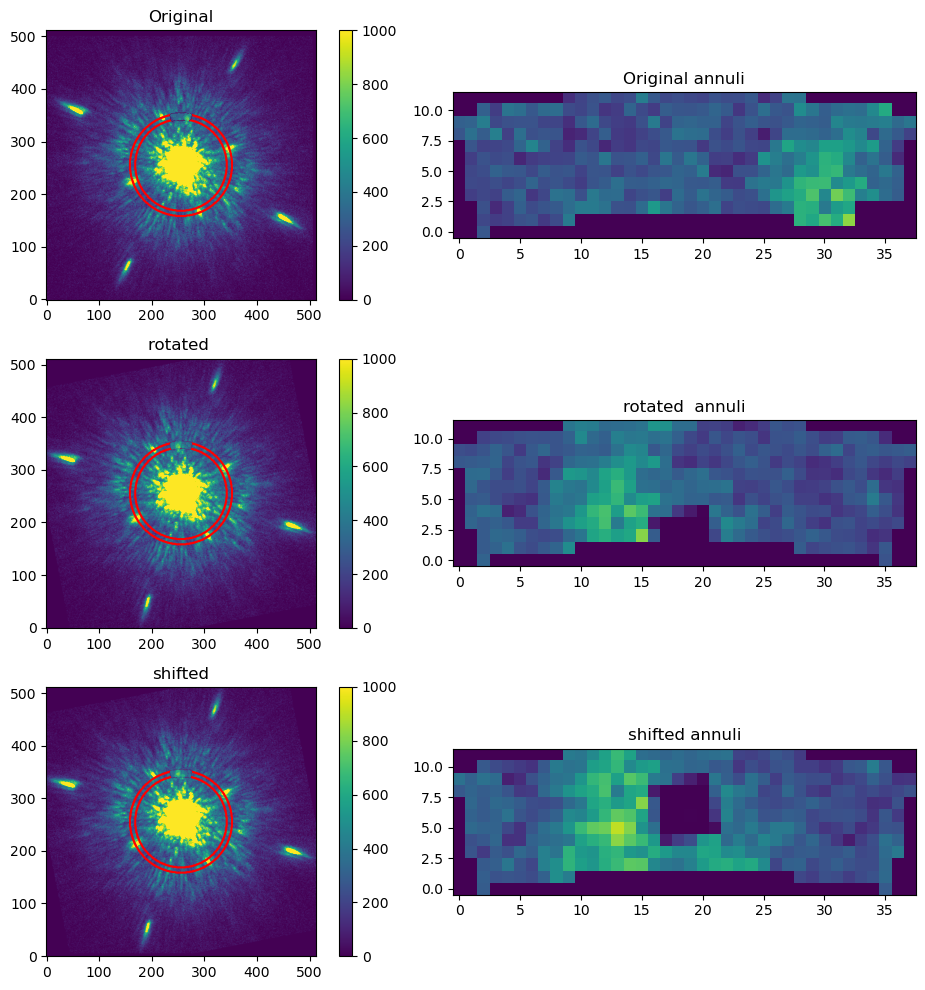

angle: 10.799515869731465
New pixel location after rotation: (255.5, 343.5596388818396)
or size: (512, 512)
or_center: (347.5, 255.5)
255.5 255.5
Shifting by (y,x): (3.9403611181604106, 0)
center_y: 255.5., new_y: 343.5596388818396., OR_center: 347.5 
masked


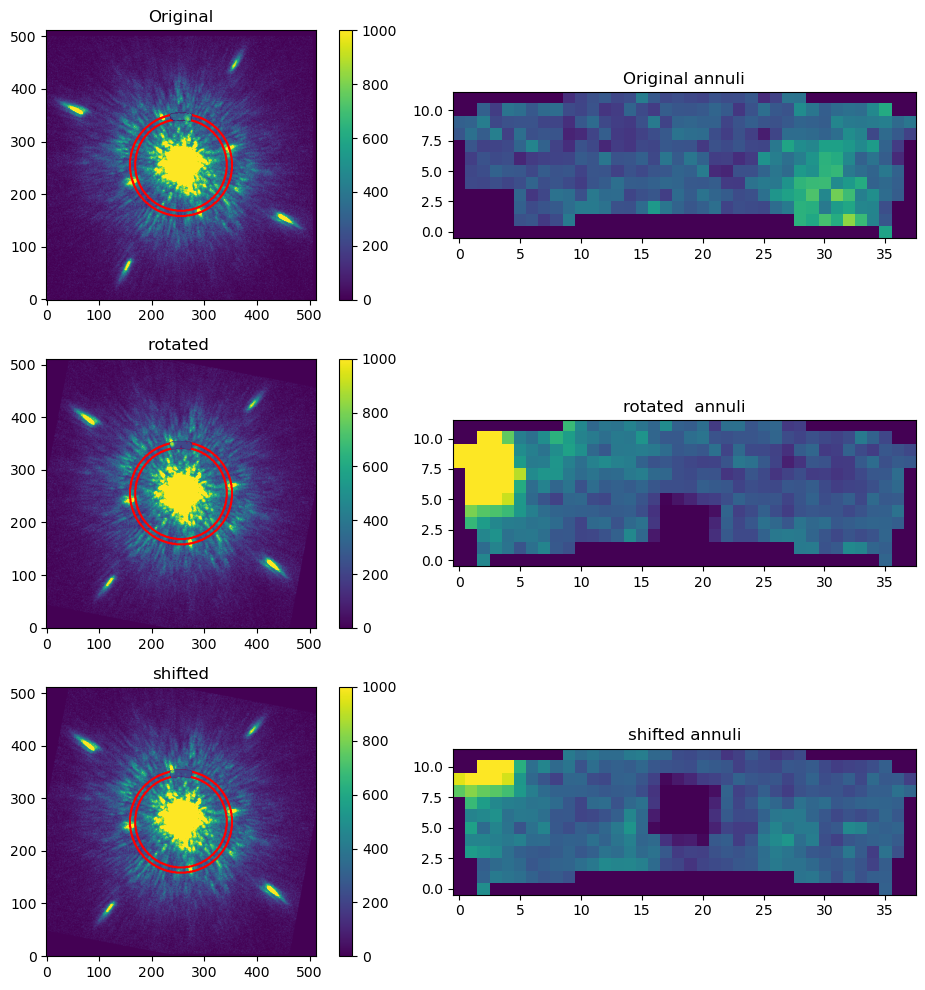

angle: 10.159055995846813
New pixel location after rotation: (255.5, 343.3777560023013)
or size: (512, 512)
or_center: (347.5, 255.5)
255.5 255.5
Shifting by (y,x): (4.1222439976987175, 0)
center_y: 255.5., new_y: 343.3777560023013., OR_center: 347.5 
masked


KeyboardInterrupt: 

In [29]:
import numpy as np
from skimage.transform import rotate
import math
from scipy.ndimage import shift, center_of_mass
from scipy.interpolate import RectBivariateSpline
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize


import matplotlib as mpl


def plot_image(ax, title, image_full, image_cropped, SR_m, masking, xsp_i=None, ysp_i=None, annotations:str=None, vmin=None, vmax=None):
    # vmin = np.min(image_full)
    # vmax = np.max(image_full)
    # print(f"global min, max: {vmin}, {vmax}")
    
    # Plot the full image with colorbar
    im = ax[0].imshow(image_full, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    ax[0].set_title(title)
    ax[0].contour(SR_m, levels=[0.5], colors='red')
    ax[0].contour(masking)
    ax[0].invert_yaxis()
    plt.colorbar(im, ax=ax[0])  # Add colorbar here

    # Plot the cropped image
    ax[1].imshow(image_cropped, vmin= vmin, vmax=vmax, cmap='viridis')
    ax[1].set_title(f"{title} annuli")
    ax[1].invert_yaxis()


    if annotations:
        ax[0].annotate(annotations, xy=(xsp_i, ysp_i), xytext=(3, 10), arrowprops=dict(facecolor='black', shrink=0.5))

def calculate_new_pixel_location(XSP_i, YSP_i, center_x, center_y, angle):
    """
    Calculates the new pixel location after rotation.
    """
    # Convert the angle to radians for rotation matrix
    theta = -np.radians(angle)
    
    # Apply the 2D rotation matrix to find the new coordinates
    new_x = center_x + np.cos(theta) * (XSP_i - center_x) - np.sin(theta) * (YSP_i - center_y)
    new_y = center_y + np.sin(theta) * (XSP_i - center_x) + np.cos(theta) * (YSP_i - center_y)

    return new_x, new_y


def search_region(image, srpix_inner, srpix_outer, wedge_angle):
    center = ((image.shape[0] - 1) / 2, (image.shape[1] - 1) / 2)  # floats
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    cy, cx = center  #full image center

    # Calculate distances from the center
    distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)

    # Create search region
    SR_mask = (distance > srpix_inner) & (distance < srpix_outer)

    # Calculate angles
    angle = np.arctan2(y - cy, x - cx)
    angle = (angle + 2 * np.pi) % (2 * np.pi)

    # Define north or upward direction angle (270 degrees in radians) on full image
    north_angle = np.pi / 2

    # Create the OR mask
    OR_mask = (angle > north_angle - wedge_angle / 2) & (angle < north_angle + wedge_angle / 2) & SR_mask
    
    #calc geometric center of or
    OR_center_y = cy + 0.5 * (srpix_inner + srpix_outer) * np.sin(north_angle)
    OR_center_x = cx + 0.5 * (srpix_inner + srpix_outer) * np.cos(north_angle)
    OR_center = (OR_center_y, OR_center_x)
    print(f"or size: {OR_mask.shape}")
    print(f"or_center: {OR_center}")

    print(cy, cx)
    return SR_mask, OR_mask, OR_center


def resize_image(image):
    return image  # Placeholder for the actual resizing logic


def process_search_region(image, srpix_inner, srpix_outer,
                          wedge_angle, vmin, vmax):
    XAP = 0
    YAP = 0.5 * (srpix_outer + srpix_inner)

    center_y, center_x = ((image.shape[0] - 1) / 2, (image.shape[1] - 1) / 2)
    SR_m, OR_m, OR_center = search_region(image, srpix_inner, srpix_outer, wedge_angle)
    print(f"ormask: {OR_m.shape}")
    processed_images = []
    count = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if OR_m[y, x]:
                XSP_i, YSP_i = x, y
                ISPi = image[YSP_i, XSP_i]

                # Create a copy of the original image to blackout pixels
                image_copy = image.copy()#only for testing purposes
                
                # Black out the first pixel and surrounding pixels
                radius = 2  # Define the radius of surrounding pixels to black out
                for dy in range(-radius, radius +1):
                    for dx in range(-radius, radius +1):
                        ny, nx = YSP_i + dy, XSP_i + dx
                        if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]:
                            image_copy[ny, nx] = 0

                angle = np.degrees(np.arctan2( YSP_i - center_y, XSP_i - center_x )) - 90
                print(f"angle: {angle}")

                rotated_image = rotate(image_copy, angle= angle, order=3, resize=False, preserve_range=True, center=(center_x, center_y))
            # calc new pixel loc
                new_x, new_y = calculate_new_pixel_location(XSP_i, YSP_i, center_x, center_y, angle)
                print(f"New pixel location after rotation: ({new_x}, {new_y})")
                '''possible shift error due to the image changing shape when rotating?'''
                _ ,_, OR_center_rotated = search_region(rotated_img, srpix_inner, srpix_outer, wedge_angle)

            # geometric calc of OR center after rotation. make sure to keep accurate
                rotated_or_center_y = center_y - 0.5 * (srpix_inner + srpix_outer)* np.cos(np.radians(angle))
                rotated_or_center_x = center_x - 0.5 * (srpix_inner + srpix_outer) * np.sin(np.radians(angle))
                rotated_or_center = (rotated_or_center_y, rotated_or_center_x)

                # Calculate shift to move new pixel location to the Analysis Point (XAP, YAP)
                shift_x = 0
                shift_y =  -1 * ((new_y - center_y) - (OR_center[0] - center_y))   #rotated_or_center_y - new_y  #or_center is taken from original image
                shifted_image = shift(rotated_image, shift=[shift_y, shift_x], order=3)
                print(f"Shifting by (y,x): ({shift_y}, {shift_x})")

                print(f"center_y: {center_y}., new_y: {new_y}., OR_center: {OR_center[0]} ")
                #just the cutouts
                masked_image = image_copy * OR_m
                print('masked')
                masked_image_rotated = rotated_image * OR_m
               # plt.imshow(masked_image_rotated)
               # plt.show()
                masked_image_shifted = shifted_image * OR_m

                non_zero_rows = np.any(masked_image, axis=1)
                non_zero_cols = np.any(masked_image, axis=0)
                rot_nonZero_rows = np.any(masked_image_rotated, axis=1)
                rot_nonZero_cols = np.any(masked_image_rotated, axis=0)
                shift_nonZero_rows = np.any(masked_image_shifted, axis=1)
                shift_nonZero_cols = np.any(masked_image_shifted, axis=0)

                cropped_image = masked_image[np.ix_(non_zero_rows, non_zero_cols)]
                cropped_rotated = masked_image_rotated[np.ix_(rot_nonZero_rows, rot_nonZero_cols)]
                cropped_shifted = masked_image_shifted[np.ix_(shift_nonZero_rows, shift_nonZero_cols)]

                processed_images.append(cropped_shifted)

                # print(f"Original annuli min: {cropped_image.min()}, max: {cropped_image.max()}")
                # print(f"Rotated annuli min: {cropped_rotated.min()}, max: {cropped_rotated.max()}")
                # print(f"Shifted annuli min: {cropped_shifted.min()}, max: {cropped_shifted.max()}")

                fig, axs = plt.subplots(3, 2, figsize=(10, 10), layout='tight')

                plot_image(ax=axs[0], title=f'Original', xsp_i=XSP_i, ysp_i=YSP_i, SR_m=SR_m,
                           image_full=image_copy, image_cropped=cropped_image,
                           masking=masked_image, annotations=None, vmin=vmin, vmax=vmax)
                plot_image(ax=axs[1], title=f'rotated ', xsp_i=XSP_i, ysp_i=YSP_i, SR_m=SR_m,
                           image_full=rotated_image, masking=masked_image_rotated,
                           image_cropped=cropped_rotated, annotations=None, vmin=vmin, vmax=vmax)
                plot_image(ax=axs[2], title=f"shifted", image_full=shifted_image,
                           image_cropped=cropped_shifted, xsp_i=XSP_i, ysp_i=YSP_i,
                           SR_m=SR_m, masking=masked_image_shifted, annotations=None, vmin=vmin, vmax=vmax)
                
                plt.savefig(f"./cutouts/cutout{count}")
                plt.show()
                count+=1
    return processed_images


# fits_file = "C:\\Users\\snedd\\work\\project\\raw_images\\cen_camsci1_20230316024607829066148.fits"
fits_file = "cen_camsci1_20230316015110794263351.fits"
with fits.open(fits_file) as hdul:
    image_data = np.asanyarray(hdul[0].data, dtype=float)

srpix_inner = 87
srpix_outer = 97
orDPixAng = 22.5
wedge_angle = np.radians(orDPixAng)
planet_radius = 2.5
steps = int(2 * np.pi / wedge_angle)

global_min = 0
global_max = 1000
print(f"global min, max: {global_min}, {global_max}")


mask_region = np.zeros_like(image_data)
cy, cx = (float(image_data.shape[1] - 1) / 2, float(image_data.shape[0] - 1) / 2)
y, x = np.ogrid[:image_data.shape[0], :image_data.shape[1]]
mask = ((x - cx) ** 2 + (y - cy) ** 2) <= (srpix_outer ** 2)
mask_region[mask] = 1

processed_images = []

for step in range(steps):
    rotation_angle = np.degrees(step * wedge_angle)
    rotated_img = rotate(image_data, angle=rotation_angle, center=(cy, cx), order=3, preserve_range=True)

    search_params = process_search_region(image=rotated_img, srpix_inner=srpix_inner, srpix_outer=srpix_outer,
                                            wedge_angle=wedge_angle, vmin=global_min, vmax=global_max)
    processed_images.append(search_params)
    print(f'step {step}.')
    break
    # plt.imshow(resized_cutout_planet, cmap='gray')
    # plt.show()



In [ ]:
# plt.figure(figsize=(18, 18))

# plt.subplot(2, 2, 1)
# plt.imshow(image_data, cmap='gray', norm=LogNorm())
# plt.contour(mask_region, levels=[0.5], colors='r')
# plt.title('Original Image with Search Region and Optimization Region')

# plt.subplot(2, 2, 2)
# plt.imshow(rotated_img, cmap='gray', norm=LogNorm())
# plt.contour(mask_region, levels=[0.5], colors='r')
# plt.title(f'Last Rotated Image (Angle: {rotation_angle:.2f} degrees)')

# plt.subplot(2, 2, 3)
# plt.imshow(resized_cutout_planet, cmap='gray')
# plt.title(f'Centered (N-1)/2 Convention. Shape: {resized_cutout_planet.shape}')

# plt.subplot(2, 2, 4)
# plt.imshow(annulis[4], cmap='gray')
# plt.title('Cutout Image Copy')
# plt.tight_layout()
# plt.show()
